# Predicting Over/Under 2.5 Goals for the Premier League 2023/2024

## Imports

In [2]:
import pandas as pd 
import numpy as np
from team import Team, UpdateGamei
from Betting import *
from dataset import *
from Utils import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt



C:\Users\HP\AppData\Local\Temp\ipykernel_20144\3597708908.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Prediction Function

In [3]:
def Predict(params, teams, data, mode='G'):
    """
    Predict the outcomes of future matches using logistic regression and calculate related metrics.

    Parameters:
        params (object): Object containing parameters for the prediction model.
        teams (list): List of team names.
        data (object): Object containing match data.
        mode (str): Mode of prediction. Defaults to 'G'.

    Returns:
        tuple: A tuple containing the following:
            float: The log loss of the predictions.
            ndarray: Array of predicted probabilities for all matches.
            float: The accuracy of the predictions.
            list: The cumulative profit over the betting period.
            float: The stack kelly unit.
            float: The ROI (Return on Investment).
            int: The total number of bets made.
    """
    E = np.arange(60, len(data.data) + 1, 10)
    # Update ratings
    update_ratings(params, teams, data, 60, mode, True)
    # Extract features
    X = features(params, teams, data, mode)
    # Define intervals
    intervals = np.arange(60, len(data.data) + 1, 10)
    # Initialize logistic regression model
    log_reg = LogisticRegression()
    # Get target variable
    y = data.get_y()
    # Initialize variables for betting
    all_probabilities = np.empty((0, 2))
    all_predictions = []
    T = Betting()
    # Get odds
    Under_Odds, Over_Odds = data.get_odds()
    L = []
    PROFIT = []
    # Calculate odds
    Under_Cote, Over_Cote = [1 / Under_Odds[i] for i in range(len(Over_Odds))], [1 / Over_Odds[i] for i in range(len(Under_Odds))]
    # Iterate through intervals
    for i in range(len(E) - 2):
        X_train, y_train = X[E[0] - 60: E[i + 1] - 60], y[E[0]: E[i + 1]]
        X_bet, y_bet = X[E[i + 1] - 60: E[i + 2] - 60], y[E[i + 1]: E[i + 2]]

        # Fit logistic regression model
        log_reg.fit(X_train, y_train)
        # Predict probabilities and outcomes
        probabilities = np.array(log_reg.predict_proba(X_bet))
        prediction = np.array(log_reg.predict(X_bet))
        all_probabilities = np.concatenate([all_probabilities, probabilities])
        all_predictions.extend(prediction)
        
        # Apply Kelly betting strategy
        PROFIT = T.kellybetting_unitlist(probabilities, y_bet, Over_Cote[E[i + 1] - 62: E[i + 2] - 62],
                                          Under_Cote[E[i + 1] - 62: E[i + 2] - 62], PROFIT, 0.)
        L.append(PROFIT)
    # Calculate loss and accuracy
    loss = log_loss(y[E[1]: E[len(E) - 1]], all_probabilities)
    accuracy = accuracy_score(y[intervals[1]: intervals[-1]], all_predictions)

    return loss, all_probabilities, accuracy, PROFIT/T.number_of_bets, T.stack_kelly_unit, L[-1][-1] / T.number_of_bets, T.number_of_bets



In [4]:
from scipy.optimize import minimize

def Optimize(lam, phi1, phi2,teams,Dataset,mode='G+S+C'):
    def objective_function(x):
        return Predict([x[0],x[1],x[2]],teams,Dataset,'G+S+C')[0]
    
    bounds = [(0.05, 2), (0.1, 0.95), (0.1, 0.95)] # set the bounds for the first three parameters
    
    result = minimize(objective_function, x0=[lam, phi1, phi2], bounds=bounds,method='nelder-mead',options={'disp': True})
    Xr=result.x
    return Xr,Predict([Xr[0],Xr[1],Xr[2]],teams,Dataset,'G+S+C')

## Data of season 2021/2022

In [5]:
Dataset_2122 = FootballDataset('data/Premier_League_2021_2022.csv')
data_2122 = Dataset_2122.data
teams_2122 = [Team(i,Dataset_2122.team_names()) for i in range(1,21)]
print(Dataset_2122.team_names())

{1: 'Brentford', 2: 'Arsenal', 3: 'Man United', 4: 'Leeds', 5: 'Burnley', 6: 'Brighton', 7: 'Chelsea', 8: 'Crystal Palace', 9: 'Everton', 10: 'Southampton', 11: 'Leicester', 12: 'Wolves', 13: 'Watford', 14: 'Aston Villa', 15: 'Norwich', 16: 'Liverpool', 17: 'Newcastle', 18: 'West Ham', 19: 'Tottenham', 20: 'Man City'}


## Data of Season 2022/ 2023


In [6]:
Dataset_2223 = FootballDataset('data/Premier_League_2022_2023.csv')
data_2223 = Dataset_2223.data
teams_2223 = [Team(i,Dataset_2223.team_names()) for i in range(1,21)]
print(Dataset_2223.team_names())

{1: 'Crystal Palace', 2: 'Arsenal', 3: 'Fulham', 4: 'Liverpool', 5: 'Bournemouth', 6: 'Aston Villa', 7: 'Leeds', 8: 'Wolves', 9: 'Newcastle', 10: "Nott'm Forest", 11: 'Tottenham', 12: 'Southampton', 13: 'Everton', 14: 'Chelsea', 15: 'Leicester', 16: 'Brentford', 17: 'Man United', 18: 'Brighton', 19: 'West Ham', 20: 'Man City'}


## Data of Season 2023/2024

In [7]:
Dataset_2324 = FootballDataset('data/Premier_League_2023_2024.csv')
data_2324 = Dataset_2324.data
teams_2324 = [Team(i,Dataset_2324.team_names()) for i in range(1,21)]
print(Dataset_2324.team_names())

{1: 'Burnley', 2: 'Man City', 3: 'Arsenal', 4: "Nott'm Forest", 5: 'Bournemouth', 6: 'West Ham', 7: 'Brighton', 8: 'Luton', 9: 'Everton', 10: 'Fulham', 11: 'Sheffield United', 12: 'Crystal Palace', 13: 'Newcastle', 14: 'Aston Villa', 15: 'Brentford', 16: 'Tottenham', 17: 'Chelsea', 18: 'Liverpool', 19: 'Man United', 20: 'Wolves'}


#### Random Initialization of parameters in the season 2021/2022

In [8]:
loss, all_probabilities, accuracy, PROFIT_1 ,_,_,_= Predict([1, 0.5      , 0.5    ],teams_2122,Dataset_2122,'G+S+C')


### Profit made in 2021/2022

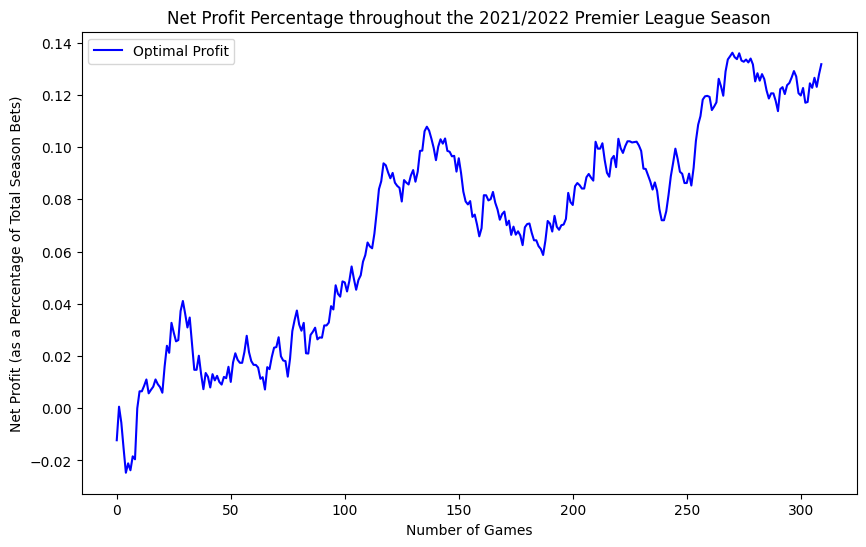

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(PROFIT_1)), PROFIT_1, label='Optimal Profit', color='blue')

plt.xlabel('Number of Games')
plt.ylabel('Net Profit (as a Percentage of Total Season Bets)')
plt.title('Net Profit Percentage throughout the 2021/2022 Premier League Season')
plt.legend()
plt.grid(False)
plt.show()

In [10]:
print_team_stats(teams_2122)

The best Home attacking team is: Man City (8.417739092703524)
The best Home defensing team is: Liverpool (0)
The best Away attacking team is: Man City (8.417739092703524)
The best Away defensing team: Liverpool (0)


The three best overall teams with the highestaverage attacking attribute are:
Man City (16.835478185407048)
Liverpool (15.3255450882219)
Chelsea (15.200861445361156)
Tottenham (11.694213090694026)
Brentford (10.316871932689414)
Aston Villa (8.974480084907354)
Arsenal (8.659164452920876)
Leeds (7.647233572586876)
Man United (6.584042772566821)
Crystal Palace (6.322326990369916)


The three best overall teams with the highest average defendingattribute are:
Liverpool (0)
Man City (0.5594250878562257)
Crystal Palace (3.328375292191119)
Newcastle (3.6891120550722656)
Brighton (4.3103088872790245)
Arsenal (5.034246845190097)
Tottenham (6.141072575179653)
West Ham (6.750805884316966)
Aston Villa (7.706435880586378)
Chelsea (8.08017659319026)




#### Keep 2/3 of the ratings of the teams that stayed in the league

In [11]:
for i in range(0,20):
    if teams_2122[i].name == teams_2223[i].name:
        a,b,c,d=np.array(teams_2122[i].get())*(2/3)
        teams_2223[i].update(a,b,c,d)

### Optimize parameters of the GAP Ratings for the next season

In [13]:
params = [1. ,0.5,0.5]
Optimize(0.5,0.515,0.5,teams_2122,Dataset_2122,'G+S+C')

Optimization terminated successfully.
         Current function value: 0.695722
         Iterations: 67
         Function evaluations: 135


(array([0.59460302, 0.93302104, 0.85300847]),
 (0.6957222857116296,
  array([[0.54322562, 0.45677438],
         [0.32705472, 0.67294528],
         [0.40067719, 0.59932281],
         [0.42427753, 0.57572247],
         [0.4732825 , 0.5267175 ],
         [0.39382562, 0.60617438],
         [0.42144619, 0.57855381],
         [0.54040533, 0.45959467],
         [0.53421943, 0.46578057],
         [0.42170611, 0.57829389],
         [0.44595242, 0.55404758],
         [0.43220882, 0.56779118],
         [0.38101437, 0.61898563],
         [0.48553781, 0.51446219],
         [0.46923285, 0.53076715],
         [0.42113717, 0.57886283],
         [0.37458648, 0.62541352],
         [0.46122399, 0.53877601],
         [0.49945999, 0.50054001],
         [0.56101332, 0.43898668],
         [0.40098836, 0.59901164],
         [0.36309477, 0.63690523],
         [0.40939475, 0.59060525],
         [0.41951114, 0.58048886],
         [0.43960904, 0.56039096],
         [0.40840394, 0.59159606],
         [0.40348066, 

In [14]:
loss, all_probabilities, accuracy, PROFIT_2 ,_,_,_= Predict([0.59460302, 0.93302104, 0.85300847    ],teams_2223,Dataset_2223,'G+S+C')


In [15]:
Predict([0.59460302, 0.93302104, 0.85300847    ],teams_2223,Dataset_2223,'G+S+C')

(0.7017258000187669,
 array([[0.39481316, 0.60518684],
        [0.3680092 , 0.6319908 ],
        [0.40255758, 0.59744242],
        [0.53414441, 0.46585559],
        [0.40113624, 0.59886376],
        [0.36657989, 0.63342011],
        [0.39771386, 0.60228614],
        [0.35577111, 0.64422889],
        [0.4246593 , 0.5753407 ],
        [0.33543234, 0.66456766],
        [0.18189315, 0.81810685],
        [0.31448458, 0.68551542],
        [0.23342948, 0.76657052],
        [0.54742567, 0.45257433],
        [0.21392845, 0.78607155],
        [0.40112245, 0.59887755],
        [0.25987122, 0.74012878],
        [0.16836986, 0.83163014],
        [0.45717036, 0.54282964],
        [0.12164942, 0.87835058],
        [0.45153341, 0.54846659],
        [0.25188809, 0.74811191],
        [0.36654084, 0.63345916],
        [0.31747847, 0.68252153],
        [0.35454853, 0.64545147],
        [0.41120289, 0.58879711],
        [0.16771236, 0.83228764],
        [0.38896168, 0.61103832],
        [0.45283126, 0.5471

In [16]:
for i in range(0,20):
    if teams_2223[i].name == teams_2324[i].name:
        a,b,c,d=np.array(teams_2223[i].get())*(2/3)
        teams_2324[i].update(a,b,c,d)

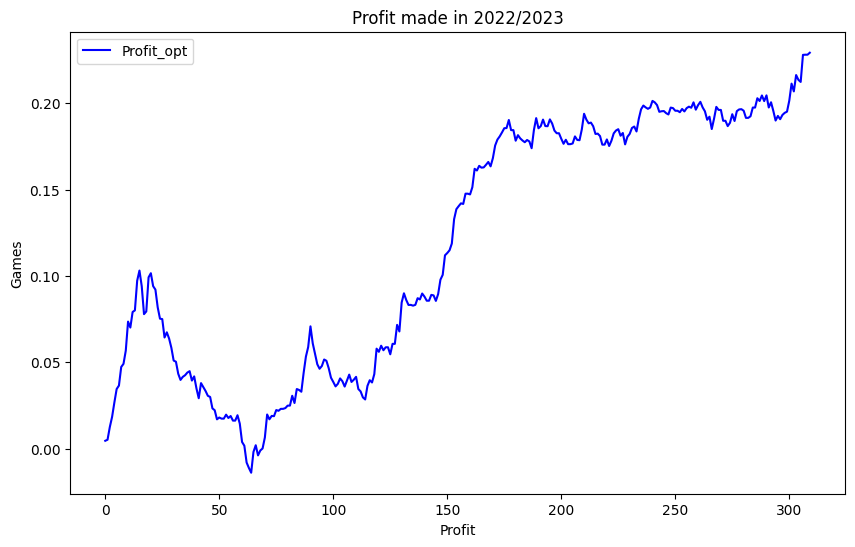

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(PROFIT_2)),PROFIT_2, label='Profit_opt', color='blue')

plt.xlabel('Profit')
plt.ylabel('Games')
plt.title('Profit made in 2022/2023')
plt.legend()
plt.grid(False)
plt.show()

Last Season 2023 2024


In [18]:
Optimize(0.59460302, 0.93302104, 0.85300847,teams_2223,Dataset_2223,'G+S+C')

Optimization terminated successfully.
         Current function value: 0.701100
         Iterations: 58
         Function evaluations: 118


(array([0.86100925, 0.62065162, 0.82095073]),
 (0.7011002929477533,
  array([[0.4215972 , 0.5784028 ],
         [0.36941068, 0.63058932],
         [0.42716905, 0.57283095],
         [0.61728751, 0.38271249],
         [0.45015717, 0.54984283],
         [0.36695398, 0.63304602],
         [0.41469033, 0.58530967],
         [0.33231301, 0.66768699],
         [0.49640592, 0.50359408],
         [0.34721349, 0.65278651],
         [0.17014324, 0.82985676],
         [0.28870386, 0.71129614],
         [0.23207992, 0.76792008],
         [0.52410203, 0.47589797],
         [0.25253644, 0.74746356],
         [0.42327288, 0.57672712],
         [0.23577062, 0.76422938],
         [0.19507895, 0.80492105],
         [0.45376835, 0.54623165],
         [0.168161  , 0.831839  ],
         [0.42718952, 0.57281048],
         [0.27036833, 0.72963167],
         [0.36124859, 0.63875141],
         [0.33110117, 0.66889883],
         [0.35501743, 0.64498257],
         [0.43854603, 0.56145397],
         [0.18556052, 

In [19]:
Predict([0.86100925, 0.62065162, 0.82095073   ],teams_2324,Dataset_2324,'G+S+C')

(0.6587582275333498,
 array([[0.53269728, 0.46730272],
        [0.48338852, 0.51661148],
        [0.4925666 , 0.5074334 ],
        [0.54909162, 0.45090838],
        [0.50838832, 0.49161168],
        [0.47222207, 0.52777793],
        [0.60291378, 0.39708622],
        [0.53990053, 0.46009947],
        [0.60776798, 0.39223202],
        [0.55250025, 0.44749975],
        [0.46885646, 0.53114354],
        [0.42900579, 0.57099421],
        [0.42575507, 0.57424493],
        [0.48146846, 0.51853154],
        [0.44456783, 0.55543217],
        [0.46990073, 0.53009927],
        [0.4176101 , 0.5823899 ],
        [0.48622899, 0.51377101],
        [0.50989406, 0.49010594],
        [0.47767938, 0.52232062],
        [0.36289644, 0.63710356],
        [0.34116745, 0.65883255],
        [0.41134541, 0.58865459],
        [0.30853499, 0.69146501],
        [0.36089661, 0.63910339],
        [0.40458127, 0.59541873],
        [0.40725202, 0.59274798],
        [0.451951  , 0.548049  ],
        [0.37161119, 0.6283

In [20]:
loss, all_probabilities, accuracy, PROFIT_3 ,_,_,_ = Predict([0.86100925, 0.62065162, 0.82095073   ],teams_2324,Dataset_2324,'G+S+C')

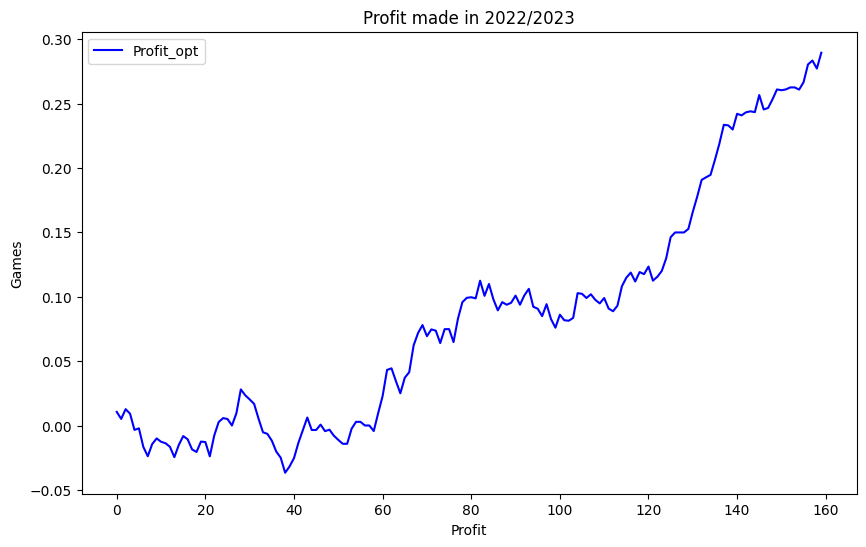

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(PROFIT_3)),PROFIT_3, label='Profit_opt', color='blue')

plt.xlabel('Profit')
plt.ylabel('Games')
plt.title('Profit made in 2022/2023')
plt.legend()
plt.grid(False)
plt.show()

In [22]:
Total_Profit = np.concatenate((PROFIT_1, PROFIT_1[-1]+PROFIT_2,PROFIT_1[-1]+PROFIT_2[-1]+PROFIT_3))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


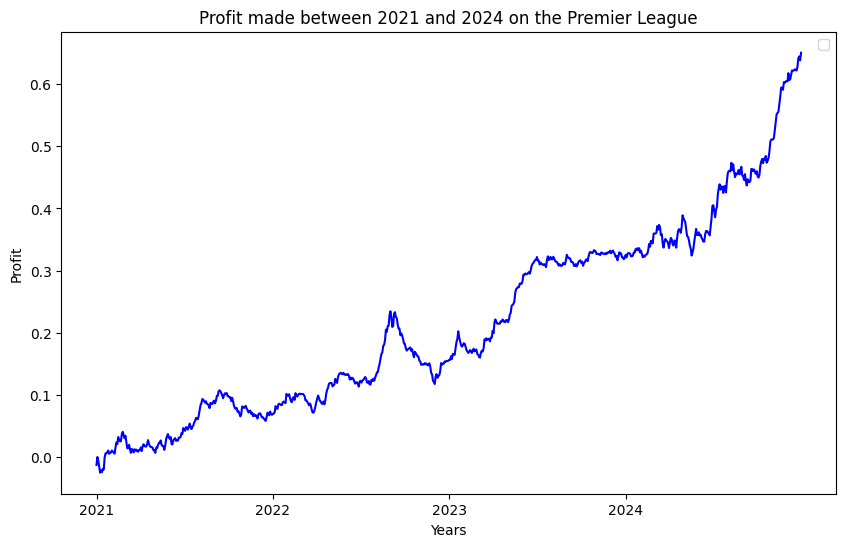

In [23]:
years = range(2021, 2025)  # Years 2022, 2023, and 2024

plt.figure(figsize=(10, 6))
plt.plot(range(len(Total_Profit)), Total_Profit, color='blue')

# Customize x-axis ticks to display years instead of game numbers
plt.xticks(range(0, len(Total_Profit), len(Total_Profit) // len(years)), years)

plt.xlabel('Years')
plt.ylabel('Profit')
plt.title('Profit made between 2021 and 2024 on the Premier League')
plt.legend()
plt.grid(False)
plt.show()

In [1]:
import pickle as pkl
with open('data/total_profit_Serie_A.pkl','rb') as f:
    Total_Profit_serie_A  = pkl.load(f)

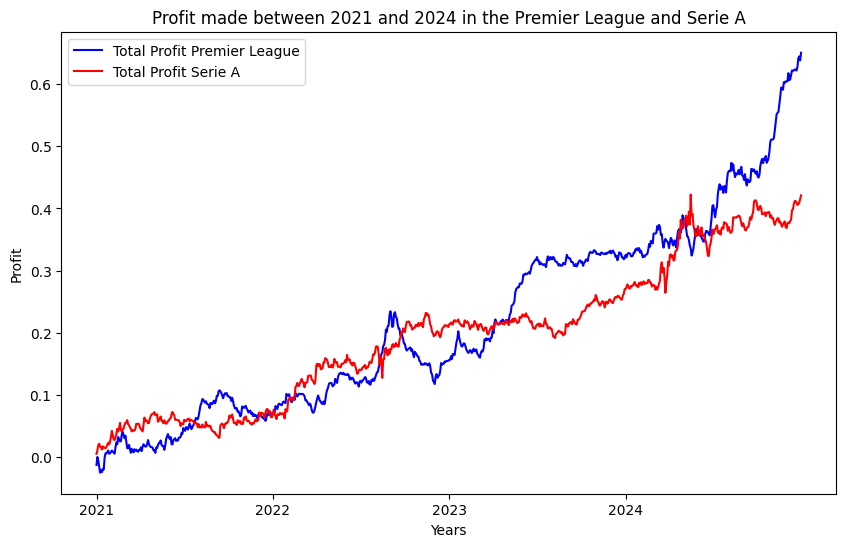

In [29]:
import matplotlib.pyplot as plt

# Assuming Total_Profit_serie_A is already defined
# Assuming years and Total_Profit are already defined

plt.figure(figsize=(10, 6))

# Plot Total_Profit
plt.plot(range(len(Total_Profit)), Total_Profit, color='blue', label='Total Profit Premier League')

# Plot Total_Profit_serie_A
plt.plot(range(len(Total_Profit_serie_A)), Total_Profit_serie_A, color='red', label='Total Profit Serie A')

# Customize x-axis ticks to display years instead of game numbers
plt.xticks(range(0, len(Total_Profit), len(Total_Profit) // len(years)), years)  # Adjusted this line

plt.xlabel('Years')
plt.ylabel('Profit')
plt.title('Profit made between 2021 and 2024 in the Premier League and Serie A')
plt.legend()
plt.grid(False)
plt.show()

